In [ ]:
import csv
import random
import os
from datetime import datetime, timedelta

# ----------------------------
# Helper Functions
# ----------------------------

def compute_age(birth_date, current_date):
    """Return the user's age in years at current_date."""
    age = current_date.year - birth_date.year
    if (current_date.month, current_date.day) < (birth_date.month, birth_date.day):
        age -= 1
    return age

def approximate_pushup_capacity(age, weight, gender):
    """
    Returns a rough 'baseline' push-up capacity with more controlled variance.
    """
    base = 0
    variance = 5  # Reduced overall variance
    if gender == 'Male':
        base = 15 + random.randint(-variance, variance)
        if age < 20:
            base += random.randint(2, 5)
        elif age > 40:
            base -= random.randint(1, 3)
        elif age > 60:
            base -= random.randint(3, 6)
        if weight < 60:
            base += random.randint(1, 3)
        elif weight > 80:
            base -= random.randint(1, 2)
        elif weight > 100:
            base -= random.randint(2, 4)
    else:  # Female
        base = 8 + random.randint(-variance, variance)
        if age < 20:
            base += random.randint(1, 3)
        elif age > 40:
            base -= random.randint(0, 2)
        elif age > 60:
            base -= random.randint(1, 4)
        if weight < 50:
            base += random.randint(0, 2)
        elif weight > 70:
            base -= random.randint(0, 2)
        elif weight > 90:
            base -= random.randint(1, 3)
    base += random.randint(-3, 3)  # Further controlled randomness
    return max(base, 1)

def update_pushups_realistic_with_frequency(pushups_prev, gender, plateau_state, frequency, days_since_last, stagnation_phase):
    if plateau_state['count'] > 0:
        plateau_state['count'] -= 1
        return pushups_prev

    if stagnation_phase['active'] and stagnation_phase['duration'] > 0:
        stagnation_phase['duration'] -= 1
        return pushups_prev
    elif stagnation_phase['active'] and stagnation_phase['duration'] == 0:
        stagnation_phase['active'] = False
        stagnation_phase['slow_gain_duration'] = random.randint(3, 7) # Define a short slow gain period
        stagnation_phase['slow_gain_count'] = 0

    base_increment = 0.0
    bad_day_factor = 1.0
    good_day_factor = 1.0
    increment_variance = 0.6 # Further reduced variance in increments
    direct_change_variance = 1.2 # Further reduced variance in direct changes
    slow_gain_factor = 0.3 # Factor for slow gains

    # Realistic slowing of progress at higher rep counts
    progression_scaling_factor = 1.0
    if gender == 'Male':
        if pushups_prev > 40:
            progression_scaling_factor = max(0.2, 1.0 - (pushups_prev - 40) * 0.05) # Slower after 40
        elif pushups_prev > 20:
            progression_scaling_factor = max(0.5, 1.0 - (pushups_prev - 20) * 0.01) # Slightly slower after 20
        if pushups_prev < 15:
            base_increment = random.uniform(1.0, 2.0)
        elif pushups_prev < 30:
            base_increment = random.uniform(0.7, 1.4)
        elif pushups_prev < 50:
            base_increment = random.uniform(0.4, 0.8)
        else:
            base_increment = random.uniform(0.2, 0.5)
        bad_day_factor = random.uniform(0.5, 0.9)
        good_day_factor = random.uniform(1.1, 1.5)
    else:
        if pushups_prev > 30:
            progression_scaling_factor = max(0.2, 1.0 - (pushups_prev - 30) * 0.06) # Slower after 30
        elif pushups_prev > 15:
            progression_scaling_factor = max(0.5, 1.0 - (pushups_prev - 15) * 0.02) # Slightly slower after 15
        if pushups_prev < 10:
            base_increment = random.uniform(0.8, 1.6)
        elif pushups_prev < 20:
            base_increment = random.uniform(0.5, 1.2)
        elif pushups_prev < 35:
            base_increment = random.uniform(0.3, 0.7)
        else:
            base_increment = random.uniform(0.15, 0.4)

    frequency_multiplier = frequency / 3.0
    rest_factor = min(1.0, days_since_last / (7 / frequency + 1e-6))
    increment = base_increment * frequency_multiplier * rest_factor * progression_scaling_factor

    if stagnation_phase['slow_gain_duration'] > 0 and stagnation_phase['slow_gain_count'] < stagnation_phase['slow_gain_duration']:
        increment *= slow_gain_factor # Apply slow gain
        stagnation_phase['slow_gain_count'] += 1
    else:
        increment += random.uniform(-increment_variance * frequency_multiplier * rest_factor, increment_variance * frequency_multiplier * rest_factor)

        good_day_chance = 0.25
        bad_day_chance = 0.20

        if random.random() < good_day_chance:
            increment *= good_day_factor
        elif random.random() < bad_day_chance:
            increment *= bad_day_factor

        plateau_chance = 0.003 * (1 - frequency_multiplier) # Slightly increased plateau chance
        if random.random() < plateau_chance:
            plateau_state['count'] = random.randint(1, 4) # Slightly longer plateaus
            increment = 0

        direct_change_chance = 0.4
        if random.random() < direct_change_chance:
            change = random.choice([-1, 1]) * frequency_multiplier * random.uniform(0.4, direct_change_variance)
            increment += change

        recent_change_factor = 1 + random.uniform(-0.08, 0.15) # Reduced influence
        increment *= recent_change_factor

        # Chance to enter a stagnation phase after some progress
        if not stagnation_phase['active'] and random.random() < 0.05:
            stagnation_phase['active'] = True
            stagnation_phase['duration'] = random.randint(2, 5) # Stagnant for a few sessions

    new_value = pushups_prev + increment
    return max(1, round(new_value))

def update_weight(weight_prev, gender):
    """Slightly smaller random weight fluctuations with a tendency towards a set point."""
    set_point_male = random.uniform(70, 85)
    set_point_female = random.uniform(55, 70)
    drift_factor = 0.01

    if random.random() < 0.15: # Further reduced chance of weight change
        change = random.uniform(-0.6, 0.6) # Even smaller fluctuation
        new_weight = max(40.0, weight_prev + change)
        return round(new_weight, 2)
    else:
        # Tendency to move towards the set point
        if random.random() < drift_factor:
            if gender == 'Male':
                if weight_prev < set_point_male:
                    return round(weight_prev + random.uniform(0.03, 0.15), 2)
                else:
                    return round(weight_prev - random.uniform(0.03, 0.15), 2)
            else:
                if weight_prev < set_point_female:
                    return round(weight_prev + random.uniform(0.03, 0.15), 2)
                else:
                    return round(weight_prev - random.uniform(0.03, 0.15), 2)
        return weight_prev

# ----------------------------
# Main Dataset Generation
# ----------------------------

def generate_dataset(filename="pushup_data", num_users=100, sessions_per_user=1000):
    """
    Generate a push-up dataset with more controlled and realistic variance in progression,
    including periods of stagnation and slow improvement.
    """
    start_date = datetime(2021, 1, 1)
    filename = f"{filename}.csv"

    # Delete any existing file with a similar name
    for existing_file in os.listdir():
        if filename in existing_file and existing_file.endswith(".csv"):
            try:
                os.remove(existing_file)
                print(f"Deleted existing file: {existing_file}")
            except OSError as e:
                print(f"Error deleting file {existing_file}: {e}")

    with open(filename, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["user_id","weight","age","gender","pushups","date","session_id","frequency"])

        for user_id in range(num_users):
            gender = random.choice(["Male", "Female"])
            initial_age = random.randint(15, 70)

            if gender == "Male":
                weight = round(random.uniform(55, 105), 2) # Slightly narrower weight range
            else:
                weight = round(random.uniform(45, 85), 2)  # Slightly narrower weight range

            birth_year = start_date.year - initial_age
            birth_date = datetime(birth_year, random.randint(1, 12), random.randint(1, 28))

            # Determine a more constrained initial push-up capacity
            base_capacity = approximate_pushup_capacity(initial_age, weight, gender)
            initial_pushups = max(1, int(random.gauss(base_capacity, 4))) # Even tighter Gaussian spread
            current_pushups = initial_pushups

            sessions_per_week = random.randint(2, 4) # Slightly narrower frequency range

            current_date = start_date
            session_id = 1
            plateau_state = {'count': 0}
            sessions_this_week = 0
            week_start_date = start_date.date()
            weekly_pushup_increase = 0
            last_session_date = None
            stagnation_phase = {'active': False, 'duration': 0, 'slow_gain_duration': 0, 'slow_gain_count': 0} # Track stagnation

            for _ in range(sessions_per_user):
                current_age = compute_age(birth_date, current_date)
                days_since_last = (current_date - last_session_date).days if last_session_date else 0

                writer.writerow([
                    user_id,
                    weight,
                    current_age,
                    gender,
                    current_pushups,
                    current_date.strftime("%Y-%m-%d"),
                    session_id,
                    sessions_per_week
                ])

                previous_pushups = current_pushups
                current_pushups = update_pushups_realistic_with_frequency(
                    current_pushups, gender, plateau_state, sessions_per_week, days_since_last, stagnation_phase
                )
                weekly_pushup_increase += (current_pushups - previous_pushups)
                weight = update_weight(weight, gender)

                sessions_this_week += 1
                days_between_sessions = 1
                if sessions_per_week > 0:
                    days_between_sessions = max(1, round(7 / sessions_per_week) + random.randint(-1, 1)) # Less variation in rest days

                last_session_date = current_date
                current_date += timedelta(days=days_between_sessions)
                session_id += 1

                if current_date.date() > week_start_date + timedelta(days=6):
                    weekly_pushup_increase = 0
                    week_start_date = current_date.date()
                    sessions_this_week = 0

    print(f"Realistic dataset '{filename}' generated with periods of stagnation and slow improvement.")

if __name__ == "__main__":
    generate_dataset(filename="pushup_data")

Deleted existing file: pushup_data.csv
Realistic dataset 'pushup_data.csv' generated with periods of stagnation and slow improvement.


# Install Necessary Packages & Libraries  

In [ ]:
!pip install imbalanced-learn nltk scikit-learn matplotlib seaborn

import pandas as pd
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import hstack
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Load the dataset
file_path = "pushup_data.csv"  # Update this path if needed
train_df = pd.read_csv(file_path)

# Display the first few rows
print(train_df.head())

   user_id  weight  age  gender  pushups        date  session_id  frequency
0        0   80.77   17  Female        1  2021-01-01           1          4
1        0   80.86   17  Female        1  2021-01-03           2          4
2        0   80.86   17  Female        3  2021-01-04           3          4
3        0   80.86   17  Female        3  2021-01-05           4          4
4        0   80.86   17  Female        4  2021-01-07           5          4


In [ ]:
# Load your training data
train_df = pd.read_csv('pushup_data.csv')

# Data Preprocessing
train_df['date'] = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in train_df['date']]
train_df['gender'] = pd.factorize(train_df['gender'])[0] #encode gender

# Feature Engineering
train_df['pushup_progress'] = train_df.groupby('user_id')['pushups'].diff().fillna(0)
train_df['days_difference'] = train_df['date'].diff().dt.days.fillna(1)
train_df['rate_of_progress'] = train_df['pushup_progress'] / train_df['days_difference']
train_df['cumulative_pushups'] = train_df.groupby('user_id')['pushups'].cumsum()
train_df['time_elapsed'] = train_df.groupby('user_id')['date'].transform(lambda x: (x - x.iloc[0]).dt.days)

# Prepare data for training to predict rate of progress
train_df['next_pushups'] = train_df.groupby('user_id')['pushups'].shift(-1)
train_df['next_days_difference'] = train_df.groupby('user_id')['days_difference'].shift(-1)
train_df['next_rate_of_progress'] = (train_df['next_pushups'] - train_df['pushups']) / train_df['next_days_difference']

# Drop rows with NaN in the target variable
train_df_rate = train_df.dropna(subset=['next_rate_of_progress', 'weight', 'age', 'gender', 'pushups', 'frequency', 'cumulative_pushups', 'time_elapsed']).copy()

# Select features and target variable for predicting rate of progress
features_rate = ['weight', 'age', 'gender', 'pushups', 'frequency', 'cumulative_pushups', 'time_elapsed']
target_rate = 'next_rate_of_progress'

X_rate = train_df_rate[features_rate]
y_rate = train_df_rate[target_rate]

# Scaling numerical features
scaler_rate = MinMaxScaler()
X_rate_scaled = scaler_rate.fit_transform(X_rate)

# Split data for training and testing
X_train_rate, X_test_rate, y_train_rate, y_test_rate = train_test_split(X_rate_scaled, y_rate, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model
model_rate = RandomForestRegressor(n_estimators=100, random_state=42)
model_rate.fit(X_train_rate, y_train_rate)

RandomForestRegressor(random_state=42)

In [ ]:
def predict_days_to_goal_iterative_with_history(user_profile, past_records):
    """
    Predicts the number of days to reach a push-up goal iteratively using the
    user's profile and past records to inform the starting state.
    """
    try:
        goal_reps = int(user_profile['pushup_goal'])
        current_weight = float(user_profile['weight'])
        current_age = int(user_profile['age'])
        current_gender_str = user_profile['gender']
        frequency = int(user_profile['frequency'])
    except ValueError:
        return "Error: Invalid user profile data."

    gender_encoded = 0 if current_gender_str == 'Male' else 1

    if not past_records:
        current_reps = 1 # Default starting point if no history
        cumulative_reps = 0
        time = 0
    else:
        past_df = pd.DataFrame(past_records)
        past_df['timestamp'] = pd.to_datetime(past_df['timestamp'])
        past_df = past_df.sort_values(by='timestamp')
        current_reps = int(past_df.iloc[-1]['no_of_reps'])
        start_time = past_df.iloc[0]['timestamp']
        latest_time = past_df.iloc[-1]['timestamp']
        time = (latest_time - start_time).days
        cumulative_reps = past_df['no_of_reps'].astype(int).sum()

    days = 0

    while current_reps < goal_reps:
        input_features = np.array([[current_weight, current_age, gender_encoded, current_reps, frequency, cumulative_reps, time]])
        input_features_scaled = scaler_rate.transform(input_features)
        predicted_rate = model_rate.predict(input_features_scaled)[0]

        if predicted_rate <= 0:
            return "Prediction stalled: No progress expected."

        reps_to_goal = goal_reps - current_reps
        reps_increment = min(1, reps_to_goal)
        estimated_days = reps_increment / predicted_rate
        days += estimated_days
        current_reps += reps_increment
        cumulative_reps += reps_increment
        time += estimated_days

        if days > 365 * 5:
            return "Prediction taking too long, goal might be unrealistic."

    return days

# User data
user_profile = {'username': 'xennie', 'gender': 'Female', 'weight': '78', 'age': 56, 'pushup_goal': '44', 'frequency': '3'}
past_records = [{'timestamp': '2025-03-11', 'username': 'xennie', 'no_of_reps': '2'},
                {'timestamp': '2025-03-12', 'username': 'xennie', 'no_of_reps': '2'},
                {'timestamp': '2025-03-18', 'username': 'xennie', 'no_of_reps': '3'},
                {'timestamp': '2025-03-20', 'username': 'xennie', 'no_of_reps': '5'}]

# Make the prediction using the iterative approach with history
prediction_days = predict_days_to_goal_iterative_with_history(user_profile, past_records)
print(f"Predicted number of days to reach {user_profile['pushup_goal']} push-ups for {user_profile['username']}: {prediction_days:.2f} days")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

Predicted number of days to reach 44 push-ups for xennie: 40.70 days


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

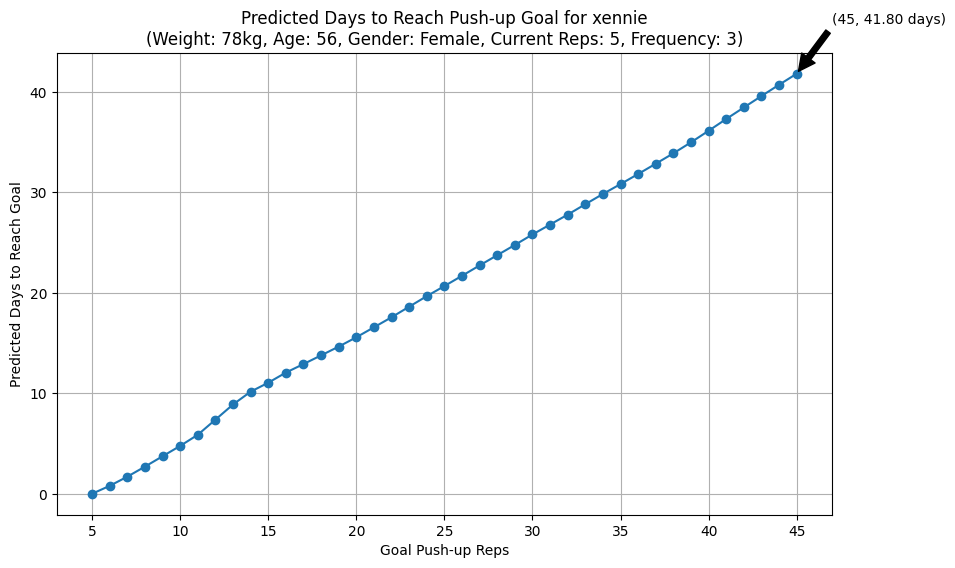

In [ ]:
# Get initial current reps from past records
if past_records:
    past_df = pd.DataFrame(past_records)
    past_df['timestamp'] = pd.to_datetime(past_df['timestamp'])
    past_df = past_df.sort_values(by='timestamp')
    current_reps_history = int(past_df.iloc[-1]['no_of_reps'])
else:
    current_reps_history = 1

# Generate a range of goal reps to plot
goal_reps_range = range(current_reps_history, int(user_profile['pushup_goal']) + 2, 1)
predicted_days_plot = []

for goal_rep in goal_reps_range:
    # Temporarily update the user profile's goal for prediction
    temp_profile = user_profile.copy()
    temp_profile['pushup_goal'] = str(goal_rep)
    prediction = predict_days_to_goal_iterative_with_history(temp_profile, past_records)
    if isinstance(prediction, str):
        predicted_days_plot.append(np.nan)
    else:
        predicted_days_plot.append(prediction)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(goal_reps_range, predicted_days_plot, marker='o', linestyle='-')
plt.title(f'Predicted Days to Reach Push-up Goal for {user_profile["username"]}\n(Weight: {user_profile["weight"]}kg, Age: {user_profile["age"]}, Gender: {user_profile["gender"]}, Current Reps: {current_reps_history}, Frequency: {user_profile["frequency"]})')
plt.xlabel('Goal Push-up Reps')
plt.ylabel('Predicted Days to Reach Goal')
plt.grid(True)

# Annotate the end point (goal reps and predicted days)
if predicted_days_plot and not isinstance(predicted_days_plot[-1], str) and np.isfinite(predicted_days_plot[-1]):
    plt.annotate(f'({goal_reps_range[-1]}, {predicted_days_plot[-1]:.2f} days)',
                 xy=(goal_reps_range[-1], predicted_days_plot[-1]),
                 xytext=(goal_reps_range[-1] + 2, predicted_days_plot[-1] + 5),
                 arrowprops=dict(facecolor='black', shrink=0.05))


plt.show()

In [ ]:
import joblib

# Save the trained model
model_filename = 'pushup_rate_prediction_model.joblib'
joblib.dump(model_rate, model_filename)

print(f"Trained model saved as {model_filename}")

# You also need to save the scaler if you're scaling input features
scaler_filename = 'pushup_rate_scaler.joblib'
joblib.dump(scaler_rate, scaler_filename)

print(f"Scaler saved as {scaler_filename}")

Trained model saved as pushup_rate_prediction_model.joblib
Scaler saved as pushup_rate_scaler.joblib
